# Transformation to OpenFOAM Code (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np

from zoomy_core.fvm.solver_jax import Settings
from zoomy_core.model.models.sme_turbulent import SMET, SMETNum

import zoomy_core.model.initial_conditions as IC
import zoomy_core.model.boundary_conditions as BC
from zoomy_core.misc.misc import Zstruct
import zoomy_core.transformation.to_openfoam as trafo
import zoomy_core.mesh.mesh as petscMesh


## Model definition

In [2]:
level = 4
offset = level+1
bcs = BC.BoundaryConditions(
    [
        BC.RoughWall(tag="wall", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)], wall_slip=1),
        BC.Extrapolation(tag="inflow"),
        BC.RoughWall(tag="outflow", momentum_field_indices=[[2+i, 2+offset+i] for i in range(level+1)], wall_slip=1),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = SMET(
    level=level,
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

# the mesh is necessary to connect the boundary conditions to the mesh tags
main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)
model.initialize_boundary_conditions(mesh)

## Sympy Model

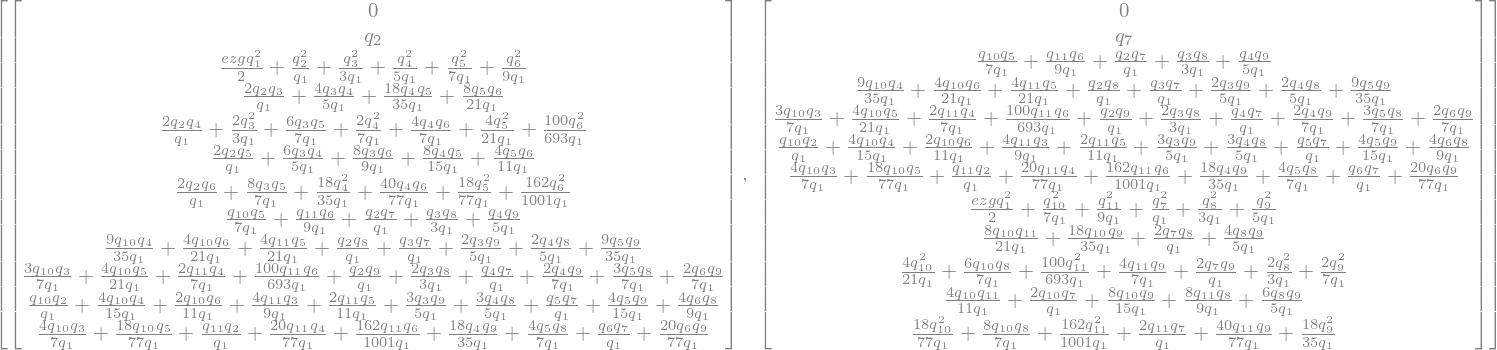

In [3]:
model.flux()

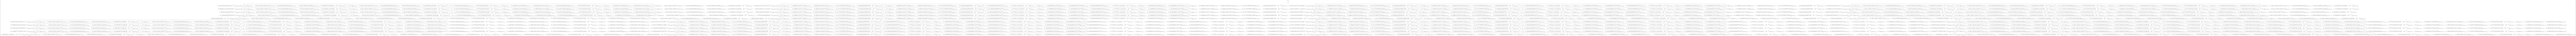

In [4]:
model.dflux()[0]

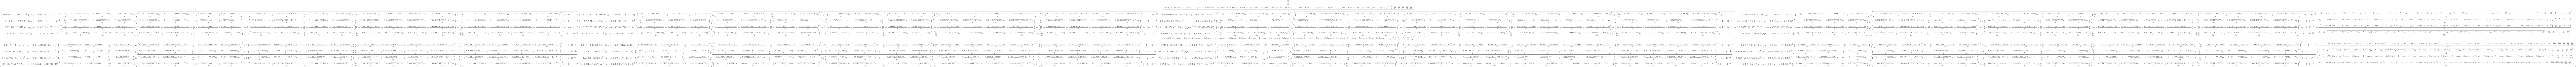

In [5]:
model.source()

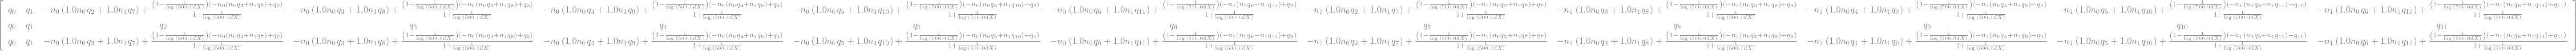

In [6]:
model.print_boundary_conditions()

## Code transformation

In [7]:
import sympy
settings = Settings(name="SMET", output=Zstruct(directory="outputs/smet", filename="smet.h5"))
trafo.write_code(model, settings, additional_writes=[{"name": "basis", "expression": sympy.Matrix(model.basisfunctions.basis), "arguments": ["z"]}])

2025-10-21 15:23:35.726 | WARNING  | library.core.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


## Check the output

In [8]:
main_dir = os.getenv("ZOOMY_DIR")
path = os.path.join(main_dir, os.path.join(settings.output.directory, '.foam_interface/Model.H'))
with open(path, "r") as f:
    print(f.read())


#pragma once
#include "List.H"
#include "vector.H"
#include "scalar.H"

namespace Model
{
constexpr int n_dof_q    = 12;
constexpr int n_dof_qaux = 25;
constexpr int dimension  = 2;
const Foam::List<Foam::word> map_boundary_tag_to_function_index{ "wall", "inflow", "outflow" };
inline Foam::scalar lambertw(const Foam::scalar x)
    {
        // valid for x > -exp(-1)
        Foam::scalar w = (x < 1.0 ? x : log(1.0 + x));  // good initial guess
        for (int i = 0; i < 5; ++i)
        {
            Foam::scalar ew = exp(w);
            Foam::scalar wew = w * ew;
            Foam::scalar diff = wew - x;
            w -= diff / (ew * (w + 1.0) - (w + 2.0) * diff / (2.0 * w + 2.0));
        }
        return w;
    }


inline Foam::List<Foam::List<Foam::scalar>> flux_x(
    const Foam::List<Foam::scalar>& Q,
    const Foam::List<Foam::scalar>& Qaux)
{
    auto res = Foam::List<Foam::List<Foam::scalar>>(12, Foam::List<Foam::scalar>(1, 0.0));
    Foam::scalar t0 = (1.0 / Foam::pow(Q[1], 1))